# EJEMPLOS OPTIMIZACIÓN DE CARTERAS CON POSICIONES EN CORTO (MARKOWITZ)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
from scipy.interpolate import interp1d

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]



pd.options.display.float_format = '{:.4%}'.format

In [2]:
# Date range
start = '2015-01-01'
end = '2019-12-30'

# Assets todos con retornos positivos
assets_positivos = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'HPQ', 'JCI', 'JPM',
        'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 'T', 'TGT', 'TMO',
        'TXT', 'VZ', 'ZION']

assets_muy_negativos = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'GE', 'HPQ', 
        'JCI', 'JPM','KHC', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

assets_un_negativo = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'HPQ', 
        'JCI', 'JPM', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

assets = assets_muy_negativos



# Downloading data
prices = yf.download(assets, start = start, end = end)['Adj Close']
prices.columns = assets

[*********************100%%**********************]  26 of 26 completed


In [3]:
#Número de activos
num_act = prices.shape[1]
returns = np.log(prices / prices.shift(1)).dropna()
matriz_cov = returns.cov().to_numpy() # Covariance matrix
retornos_esperados = returns.mean().to_numpy() # Column vector expected return

In [4]:
#Variables de decisión
pesos = cp.Variable(num_act)

# Factor aversión al riesgo
gamma = cp.Parameter(nonneg=True)

ret = retornos_esperados.T @ pesos

riesgo = cp.quad_form(pesos, matriz_cov)

In [5]:
objetivo = cp.Maximize(ret - gamma*riesgo)

In [6]:
#Restricciones y función objetivo
constraints = [pesos >= 0,
                cp.sum(pesos) == 1
                ]

prob = cp.Problem(objetivo, constraints)

In [7]:
#resolvemos para diferentes valores de gamma
num_sim = 100
riesgos_res = np.zeros(num_sim)
retornos_res = np.zeros(num_sim)
pesos_res = np.zeros((num_sim, num_act))
gamma_vals = np.logspace(-2, 3, num=num_sim)

for i in range(num_sim):
    gamma.value = gamma_vals[i]
    prob.solve()
    retornos_res[i] = ret.value
    riesgos_res[i] = cp.sqrt(riesgo).value
    pesos_res[i, :] = pesos.value

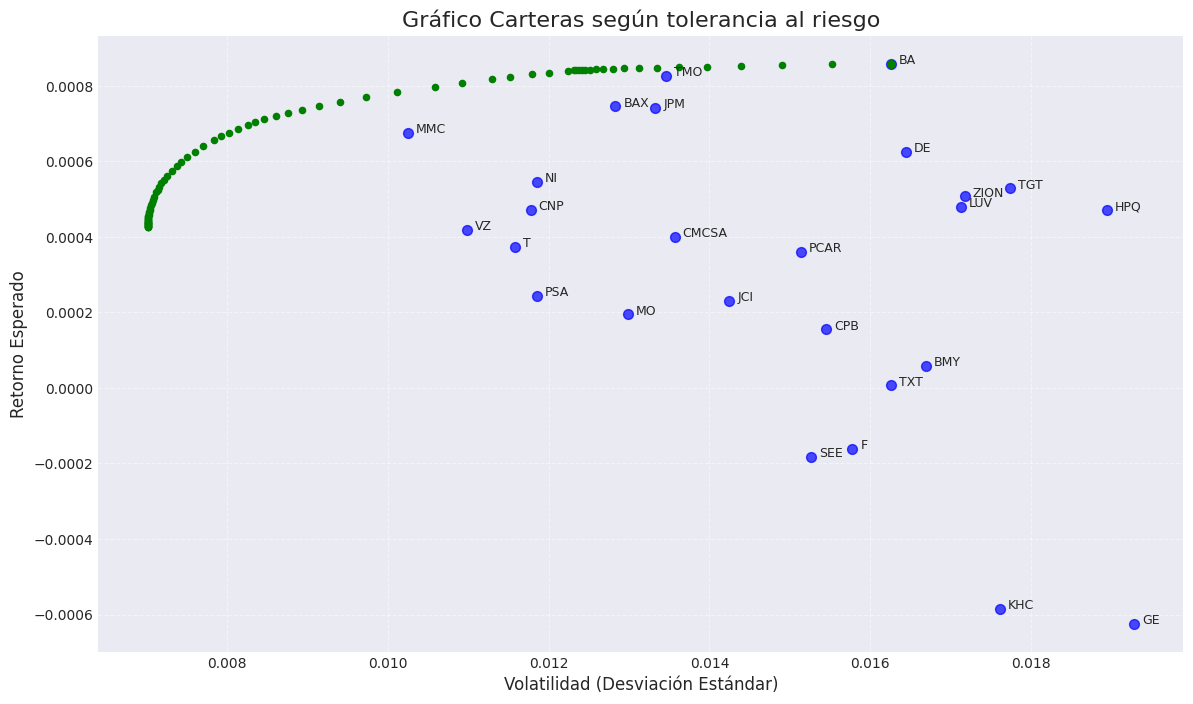

In [10]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00002  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')#,  alpha=0.3)   

# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras según tolerancia al riesgo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()


## EJEMPLOS DE CARTERAS EN DONDE **SE PERMITEN POSICIONES CORTAS**

### 1. Carteras con posiciones cortas pero límite de endeudamiento

Calcular la cartera de máxima rentabilidad, permitiendo posiciones cortas pero con un máximo en posiciones cortas

Ponerse en corto en una acción implica los siguientes pasos:

1. **Seleccionar una Acción**: Elige una acción que crees que disminuirá de valor.
   
2. **Pedir Prestada la Acción**: Solicita prestada la acción a través de tu corredor de bolsa, acordando un plazo para la devolución.
   
3. **Vender la Acción**: Vende la acción prestada en el mercado abierto.
   
4. **Recomprar la Acción**: Si el precio cae, recompra la acción a un precio más bajo antes del plazo acordado.
   
5. **Devolver la Acción**: Devuelve la acción al prestamista al finalizar el plazo pactado.
   
6.  **Beneficio**: La ganancia es la diferencia entre el precio de venta y de recompra, menos comisiones y costos.


Esto me permite conseguir financiación e invertirlo en otro activo.

Primero, veamos las rentabilidades de cada uno de los activos

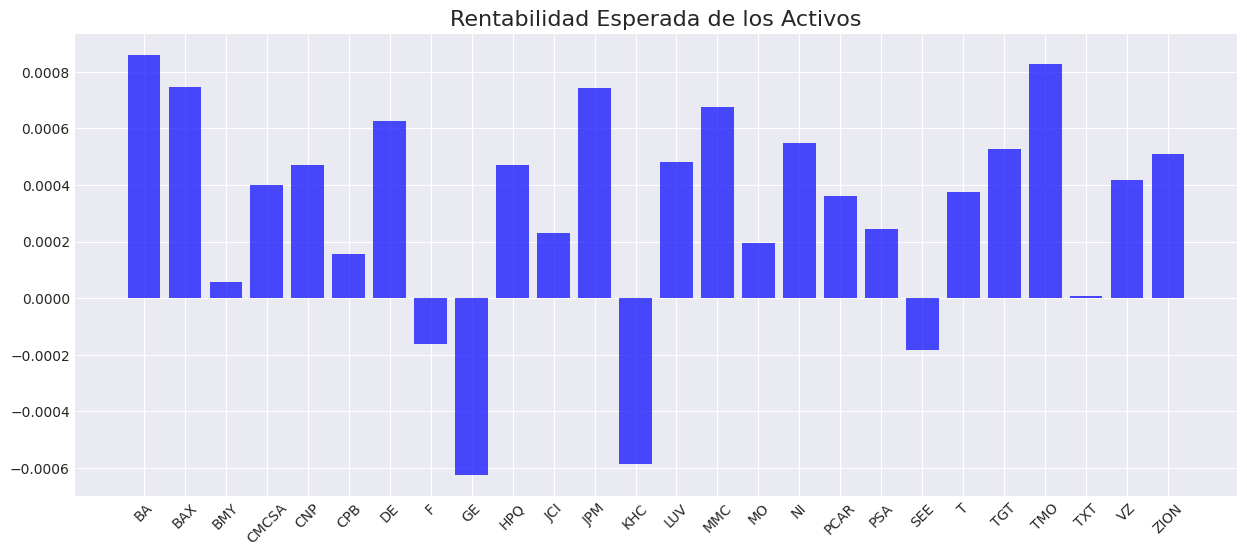

In [11]:
plt.figure(figsize=(15, 6))

plt.bar(range(len(retornos_esperados)), retornos_esperados, color='blue', alpha=0.7)

# Añadiendo los nombres de los activos como etiquetas en el eje x
plt.xticks(range(len(assets)), assets, rotation=45)

plt.title('Rentabilidad Esperada de los Activos', fontsize=16);

In [12]:
pesos = cp.Variable(num_act)

# Restricciones
constraints = [
    cp.sum(pesos) == 1,                 # La suma de los pesos debe ser igual a 1
    cp.sum(cp.abs(pesos)) <= 1.5        # El suma total de dinero invertido no debe superar el 150%
]

# Función objetivo (maximizar el retorno esperado)
retorno_esperado = retornos_esperados @ pesos
objetivo = cp.Maximize(retorno_esperado)

# Definir y resolver el problema
problema = cp.Problem(objetivo, constraints)
resultado = problema.solve(solver=cp.ECOS)

riesgo = cp.quad_form(pesos, matriz_cov)

In [13]:
pesos.value

array([ 1.24999925e+00,  3.20786063e-08,  1.17600469e-09,  5.13233561e-09,
        6.66957917e-09,  1.92483369e-09,  1.27856777e-08,  7.34458638e-10,
       -2.49999172e-01,  6.66324679e-09,  2.67343037e-09,  3.08140448e-08,
       -7.48117653e-07,  6.89907688e-09,  1.72781127e-08,  2.30723113e-09,
        8.94153017e-09,  4.43994177e-09,  2.82565241e-09,  8.39277566e-10,
        4.64186250e-09,  8.30910135e-09,  5.03713933e-07,  8.83277112e-10,
        5.48173703e-09,  7.65226513e-09])

In [14]:
pesos_ajustados = np.array([np.round(x, 3) if np.abs(x) > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x != 0]

In [15]:
print(f'Los activos que forman parte de la cartera son {np.array(assets)[pesos_ajustados != 0].tolist()}')

print(f'Los pesos que hacen que la cartera tenga el máximo retorno son: {pesos_ajustados[pesos_ajustados != 0].round(2)}')

print(f'Los retornos de los activos que forman parte de la cartera son: {retornos_esperados[pesos_ajustados != 0].round(4)}')

Los activos que forman parte de la cartera son ['BA', 'GE']
Los pesos que hacen que la cartera tenga el máximo retorno son: [ 1.25 -0.25]
Los retornos de los activos que forman parte de la cartera son: [ 0.0009 -0.0006]


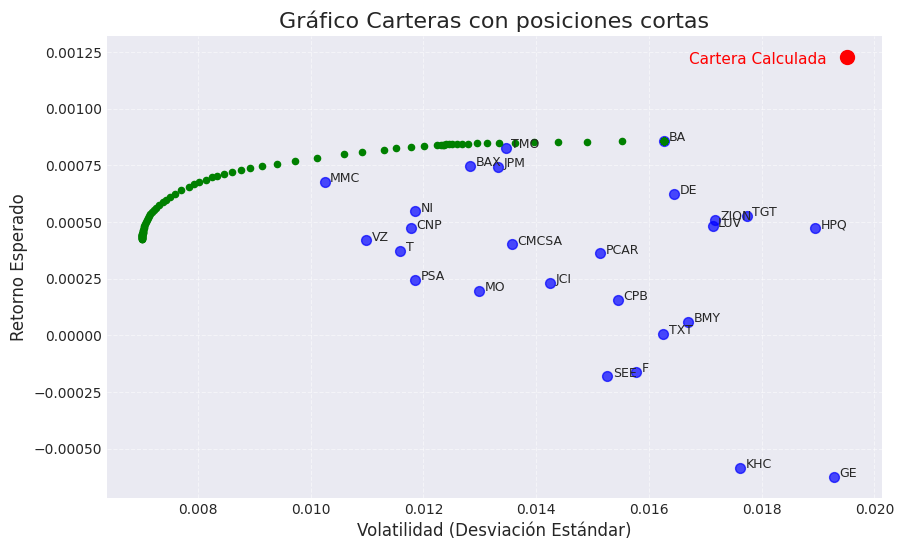

In [16]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



plt.scatter(np.sqrt(riesgo.value), resultado, color='red', s=100, marker='o')
plt.text(np.sqrt(riesgo.value) - 28*desplazamiento_x, resultado - desplazamiento_y, 'Cartera Calculada', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')


# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras con posiciones cortas', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

### 2. Cáculo de la cartera de **máxima rentabilidad según tolerancia al riesgo** variando el límite de posiciones cortas permitidas

In [17]:
cortas_max = [1.0, 1.3, 1.5, 1.7, 2.0]
resultados_df = pd.DataFrame()
num_sim = 100

In [18]:
for deuda in cortas_max:
    riesgos_res_short = np.zeros(num_sim)
    retornos_res_short = np.zeros(num_sim)
    gamma_vals = np.logspace(-2, 3, num=num_sim)

    for i in range(num_sim):
        pesos = cp.Variable(num_act)
        gamma = cp.Parameter(nonneg=True)
        gamma.value = gamma_vals[i]
        
        ret = retornos_esperados.T @ pesos
        riesgo = cp.quad_form(pesos, matriz_cov)
        objetivo = cp.Maximize(ret - gamma * riesgo)

        constraints = [cp.sum(pesos) == 1,
                       cp.sum(cp.abs(pesos)) <= deuda]
        prob = cp.Problem(objetivo, constraints)
        prob.solve()

        # Verificar el estado del problema
        if prob.status not in ["infeasible", "unbounded"]:
            retornos_res_short[i] = ret.value
            riesgos_res_short[i] = cp.sqrt(riesgo).value
        else:
            print(f"Problema no resuelto para gamma={gamma.value}: {prob.status}")

    resultados_df[f'riesgo_{deuda}'] = riesgos_res_short
    resultados_df[f'retorno_{deuda}'] = retornos_res_short

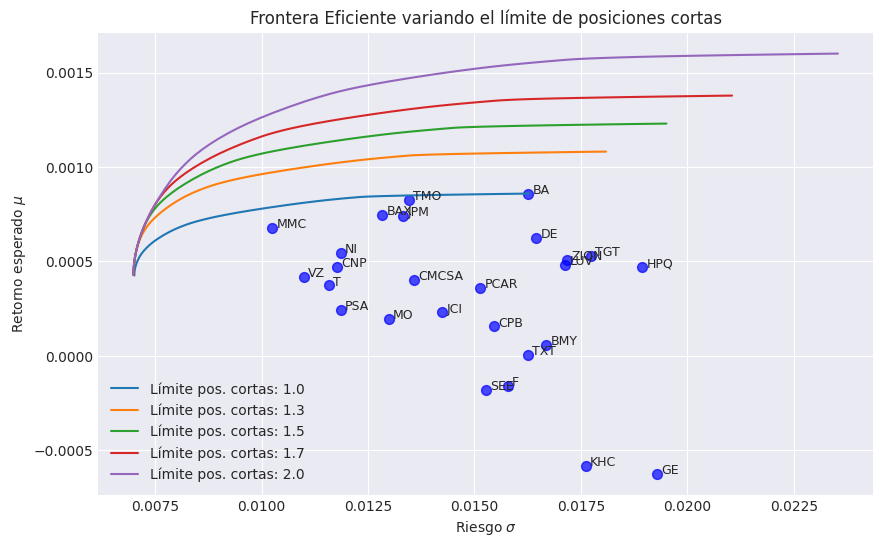

In [19]:
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

for deuda in cortas_max:
    plt.plot(resultados_df[f'riesgo_{deuda}'], resultados_df[f'retorno_{deuda}'], label=f'Límite pos. cortas: {deuda}')

plt.xlabel('Riesgo $\sigma$')
plt.ylabel('Retorno esperado $\mu$')
plt.title('Frontera Eficiente variando el límite de posiciones cortas')
plt.legend(loc='best')
plt.show()

### 3. Cáculo de la cartera de **máxima rentabilidad** limitando la posición en corto máxima en un activo 

In [4]:
pesos = cp.Variable(num_act)

# Restricciones
constraints = [
    cp.sum(pesos) == 1,
    pesos >= -0.2  # Límite de posiciones cortas
]

# Función objetivo (maximizar el retorno esperado)
retorno_esperado = retornos_esperados @ pesos
objetivo = cp.Maximize(retorno_esperado)

# Definir y resolver el problema
problema = cp.Problem(objetivo, constraints)
resultado = problema.solve(solver=cp.ECOS)

riesgo = cp.quad_form(pesos, matriz_cov)

In [5]:
pesos.value

array([ 5.99998938, -0.19999804, -0.19999992, -0.19999983, -0.19999977,
       -0.19999991, -0.19999941, -0.19999994, -0.19999995, -0.19999977,
       -0.19999989, -0.19999811, -0.19999995, -0.19999976, -0.19999907,
       -0.1999999 , -0.19999966, -0.19999985, -0.19999989, -0.19999994,
       -0.19999984, -0.1999997 , -0.19999779, -0.19999992, -0.19999982,
       -0.19999973])

In [6]:
pesos_ajustados = np.array([np.round(x, 3) if np.abs(x) > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x != 0]

In [7]:
print(f'Los activos que forman parte de la cartera son {np.array(assets)[pesos_ajustados != 0].tolist()}')

print(f'Los pesos que hacen que la cartera tenga el máximo retorno son: {pesos_ajustados[pesos_ajustados != 0].round(2)}')

Los activos que forman parte de la cartera son ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'GE', 'HPQ', 'JCI', 'JPM', 'KHC', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 'T', 'TGT', 'TMO', 'TXT', 'VZ', 'ZION']
Los pesos que hacen que la cartera tenga el máximo retorno son: [ 6.  -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2
 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2]


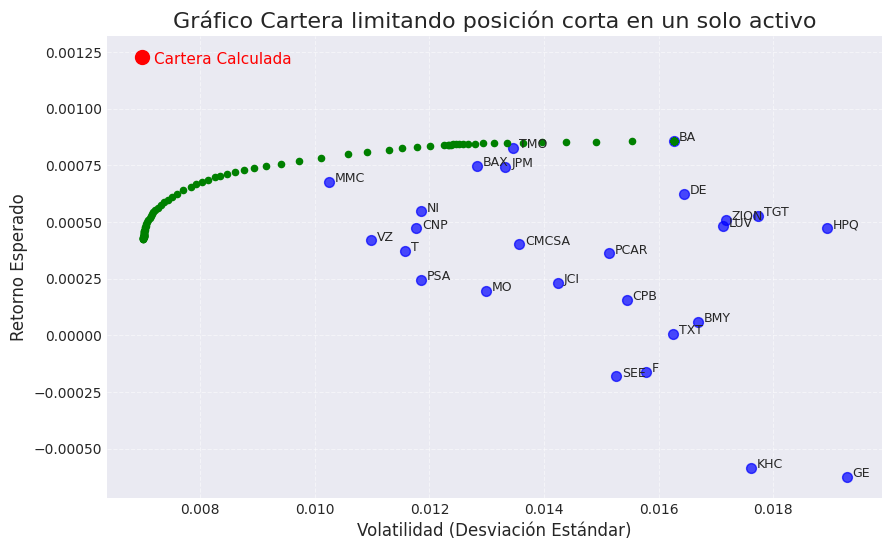

In [24]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



plt.scatter(np.sqrt(riesgo.value), resultado, color='red', s=100, marker='o')
plt.text(np.sqrt(riesgo.value) + 2*desplazamiento_x, resultado - desplazamiento_y, 'Cartera Calculada', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')


# Añadiendo títulos y etiquetas
plt.title('Gráfico Cartera limitando posición corta en un solo activo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

---

### 4. Cáculo de la cartera de **máxima rentabilidad** limitando el riesgo y la posición en corto máxima en un activo 

In [25]:
#Número de activos
num_act = prices.shape[1]
returns = np.log(prices / prices.shift(1)).dropna()
matriz_cov = returns.cov().to_numpy() # Covariance matrix
retornos_esperados = returns.mean().to_numpy() # Column vector expected return

In [26]:
pesos = cp.Variable(num_act)
riesgo = cp.quad_form(pesos, matriz_cov)

riesgo_obj = 0.014

# Restricciones
constraints = [
    cp.sum(pesos) == 1,
    pesos >= -0.2,                 # La suma de los pesos debe ser igual a 1
    riesgo <= riesgo_obj**2        # El endeudamiento total no debe superar el 30%
]

# Función objetivo (maximizar el retorno esperado)
ret = retornos_esperados @ pesos
objetivo = cp.Maximize(ret)

# Definir y resolver el problema
problema = cp.Problem(objetivo, constraints)
resultado = problema.solve(solver=cp.ECOS)

riesgo = cp.quad_form(pesos, matriz_cov)

In [27]:
max_cortos = np.array([np.sqrt(riesgo.value), ret.value])
max_cortos

array([0.014    , 0.0020352])

Calculemos ahora la **cartera equivalente pero sin posiciones cortas** para poder compararlas

In [30]:
#Variables de decisión
pesos = cp.Variable(num_act)

# Función objetivo
rentabilidad = cp.Maximize(retornos_esperados.T @ pesos)

#Restricciones
riesgo = cp.quad_form(pesos, matriz_cov)

constraints = [pesos >= 0,
                cp.sum(pesos) == 1,
                riesgo <= riesgo_obj**2
                ]

prob = cp.Problem(rentabilidad, constraints)
resultado = prob.solve(solver=cp.ECOS)
ret = retornos_esperados @ pesos

In [31]:
max_sin_cortos = np.array([np.sqrt(riesgo.value), ret.value])
max_sin_cortos

array([0.014     , 0.00085121])

In [32]:
pesos_ajustados = np.array([np.round(x, 3) if np.abs(x) > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x != 0]

In [33]:
print(f'Los activos que forman parte de la cartera son {np.array(assets)[pesos_ajustados != 0].tolist()}')

print(f'Los pesos que hacen que la cartera tenga el máximo retorno son: {pesos_ajustados[pesos_ajustados != 0].round(2)}')

Los activos que forman parte de la cartera son ['BA', 'TMO']
Los pesos que hacen que la cartera tenga el máximo retorno son: [0.76 0.24]


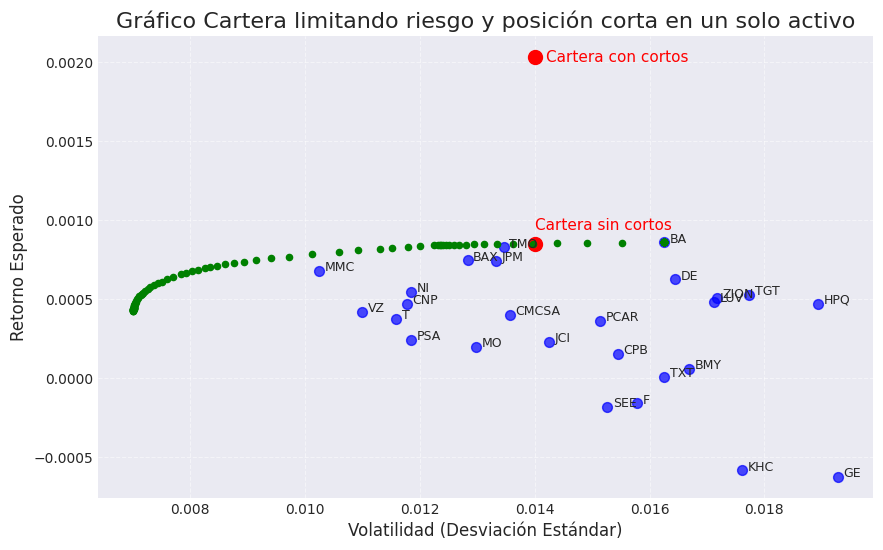

In [38]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



plt.scatter(max_cortos[0], max_cortos[1], color='red', s=100, marker='o')
plt.text(max_cortos[0] + 2*desplazamiento_x, max_cortos[1] - desplazamiento_y, 'Cartera con cortos', fontsize=11, color='red')

plt.scatter(max_sin_cortos[0], max_sin_cortos[1], color='red', s=100, marker='o')
plt.text(max_sin_cortos[0] , max_sin_cortos[1] + 3 * desplazamiento_y, 'Cartera sin cortos', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')


# Añadiendo títulos y etiquetas
plt.title('Gráfico Cartera limitando riesgo y posición corta en un solo activo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()